# Unet Implementation

In [1]:
import pickle
import gzip
import numpy as np
import os
import time
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from matplotlib import pyplot as plt
from torchsummary import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import torch.nn.functional as F

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
torch.manual_seed(19)
random.seed(19)

### Helper functions

In [4]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [5]:
def flatten(dicts):
    
    # extract the annotated video frames, their labels
    # and the boxes
    
    images = []
    labels = []
    labeled_by = []
    
    for i, dic in enumerate(dicts):
        
        video = dic['video']
        frames = dic['frames']
        dic_labels = dic['label']
        
        images.append((video[:,:,frames[0]]))
        images.append((video[:,:,frames[1]]))
        images.append((video[:,:,frames[2]]))
        
        labels.append(dic_labels[:,:,frames[0]].astype('uint8') * 255)
        labels.append(dic_labels[:,:,frames[1]].astype('uint8') * 255)
        labels.append(dic_labels[:,:,frames[2]].astype('uint8') * 255)

        if video[:,:,frames[0]].shape[0] > 112:
            labeled_by.append(1)
            labeled_by.append(1)
            labeled_by.append(1)
        else:
            labeled_by.append(0)
            labeled_by.append(0)
            labeled_by.append(0)
        
    return images, labels, labeled_by

class SegDataset(Dataset):
    
    def __init__(self, images, labels, labeled_by, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels
        self.labeled_by = labeled_by

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.labels[idx]
        label = self.labeled_by[idx]
        
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        return torch.div(image, 255).float() , torch.div(mask, 255).float(), label

### Load data

In [6]:
# load data
train_data = load_zipped_pickle("data/train.pkl")
test_data = load_zipped_pickle("data/test.pkl")

In [7]:
SIZE = 128

### Preprocessing

In [8]:
# turn dictionaries into lists of images and labels
images, labels, labeled_by = flatten(train_data)
# last 19 are expert images, take 6 of them to form validation dataset
train_images, train_labels, train_labeled_by = images[:177], labels[:177], labeled_by[:177]
val_images, val_labels, val_labeled_by = images[177:], labels[177:], labeled_by[177:]

### Augmentation

In [9]:
train_aug = A.Compose(
    [
        A.Resize(SIZE, SIZE),
        A.augmentations.geometric.transforms.Affine(
            scale=(0.9, 1.1), 
            translate_percent=(0,0.05), 
            rotate=(-20,20), 
            shear=(-20, 20), 
            p=1)
    ]
)

train_to_tensor = A.Compose(
    [
        A.Resize(SIZE, SIZE),
        A.augmentations.transforms.CLAHE(p=1),
        ToTensorV2()
    ]

)
val_to_tensor = A.Compose(
    [
        A.Resize(SIZE, SIZE),
        A.augmentations.transforms.CLAHE(p=1),
        ToTensorV2()
    ]
)

In [10]:
# copy 4 times, keep original unchanged and augment the 4 copies
# this is done in order to enlarge the training set
train_images = train_images * 5
train_labels = train_labels * 5
train_labeled_by = labeled_by * 5

In [11]:
# only augment the copies
for i in range(len(train_images) // 5, len(train_images)):
    transformed = train_aug(image=train_images[i], mask=train_labels[i])
    train_images[i] = transformed["image"]
    train_labels[i] = transformed["mask"]

In [12]:
train_dataset = SegDataset(train_images, train_labels, train_labeled_by, train_to_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, pin_memory=True, shuffle=True)
val_dataset = SegDataset(val_images, val_labels, val_labeled_by, val_to_tensor)
val_loader = DataLoader(val_dataset, batch_size=18, pin_memory=True)

### Model

In [13]:
class Unet(nn.Module):
    
    def __init__(self, filters=64, kernel=3):
        
        super().__init__()
        
        self.kernel = kernel

        self.max_pool = nn.MaxPool2d(2)
        
        self.block_enc_1 = self.conv_block(1, filters)
        self.block_enc_2 = self.conv_block(filters, 2*filters)
        self.block_enc_3 = self.conv_block(2*filters, 4*filters)
        self.block_enc_4 = self.conv_block(4*filters, 8*filters)
        
        self.block_inbetween = self.conv_block(8*filters, 16*filters, True)
        
        self.block_dec_1 = self.conv_block(16*filters, 8*filters, True)
        self.block_dec_2 = self.conv_block(8*filters, 4*filters, True)
        self.block_dec_3 = self.conv_block(4*filters, 2*filters, True)
        
        self.block_last = self.conv_block(2*filters, filters, True, True)
        
    def conv_block(self, channels, filters, dec=False, last=False):
        
        modules = []
        
        if not dec:
            modules.append(nn.Dropout(p=0.5))
            
        # modules.append(torch.nn.BatchNorm2d(channels))
        
        modules.append(nn.Conv2d(channels, filters, self.kernel, 1, padding='same'))
        modules.append(nn.ReLU())
        modules.append(nn.Conv2d(filters, filters, self.kernel, 1, padding='same'))
        modules.append(nn.ReLU())
        
        # if not decoder, then we add upscaling layer
        # if last layer, then we add conv 1x1 and sigmoid to get logits in (0, 1)
        if dec:
            if not last:
                modules.append(nn.ConvTranspose2d(filters, filters//2, 2, stride=(2,2)))
            else:
                modules.append(nn.Conv2d(filters, 1, 1, 1))
                modules.append(nn.Sigmoid())
            
        return nn.Sequential(*modules)
            
    def forward(self, x):
        
        # encoder
        
        x1 = self.block_enc_1(x)
        x2 = self.max_pool(x1)
        
        x3 = self.block_enc_2(x2)
        x4 = self.max_pool(x3)
        
        x5 = self.block_enc_3(x4)
        x6 = self.max_pool(x5)

        x7 = self.block_enc_4(x6)
        x8 = self.max_pool(x7)
        
        # between encoder and decoder
        
        x9 = self.block_inbetween(x8)
        
        # decoder
        
        x10 = self.block_dec_1(torch.cat((x9, x7), dim=1))
        x11 = self.block_dec_2(torch.cat((x10, x5), dim=1))
        x12 = self.block_dec_3(torch.cat((x11, x3), dim=1))

        x13 = self.block_last(torch.cat((x12, x1), dim=1))
        
        return x13

### Train

In [14]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, labeled_by, smooth=1):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #weight the expert images different than the amateur ones
        c = torch.ones(labeled_by.shape) * 1 - 0.5 * labeled_by
        c = torch.reshape(c, (c.shape[0], 1))
        c = c.repeat(1, SIZE*SIZE).view(-1).to(device)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        intersection = (inputs * targets * c).sum()
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [15]:
def iou_metric(inputs, targets):       
        
        # remove channel dimension (C = 1) with squeeze
        inputs = inputs.squeeze()
        
        # round to 0 or 1
        inputs = torch.round(inputs)
        
        # get intersection and union
        intersection = (inputs * targets).sum(dim=(1, 2))
        total = (inputs + targets).sum(dim=(1, 2))
        union = total - intersection 
        
        IoU = intersection / (union + 1e-6)
                
        return IoU

In [16]:
def BCELoss_class_weighted(weights):

    def loss(input, target):
        input = torch.clamp(input,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1 - input)
        return torch.mean(bce)

    return loss

In [17]:
def evaluate(model, val_loader):
    
    val_iou_list = torch.Tensor().to(device)
    
    for x,y,l in val_loader:
        
        x,y = x.to(device), y.to(device)
        output = unet(x)
        val_iou_list = torch.cat((val_iou_list, iou_metric(output, y)))
    
    return torch.median(val_iou_list), torch.min(val_iou_list)

In [18]:
# batch size 16 and 8 filters works well
unet = Unet(filters=8, kernel=3).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
criterion = IoULoss()
criterion2 = BCELoss_class_weighted(weights=(0.0001, 0.999))

### Train Loop

In [19]:
val_ious = []
train_ious = []

for epoch in range(1,150):
    
    t = time.time()
    num_samples_epoch = 0
    train_loss_cum = 0
    train_iou_list = torch.Tensor().to(device)
    
    for x,y,l in train_loader:
        
        x,y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        unet.train()
        
        output = unet(x)
        loss = criterion(output, y, l) + criterion2(output, y)
        
        loss.backward()
        optimizer.step()
        
        # keep track of training loss
        num_samples_epoch += x.shape[0]
        train_loss_cum += loss * x.shape[0]
        
        # calculate train IoU scores and concat
        unet.eval()
        with torch.no_grad():
            train_iou_list = torch.cat((train_iou_list, iou_metric(output, y)))
    
    # get median IoU on validation data
    with torch.no_grad():
        val_iou, val_iou_min = evaluate(unet, val_loader)
            
    # average train_loss
    train_loss = train_loss_cum / num_samples_epoch
    
    # get median IoU on train data
    train_iou = torch.median(train_iou_list)
    train_iou_min = torch.min(train_iou_list)   
    
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    
    epoch_duration = time.time() - t

    print(f'Epoch {epoch} | '
          f'Train loss: {train_loss:.4f} | '
          f'Train IoU: {train_iou:.4f} | '
          f'Train IoU MIN: {train_iou_min:.4f} | '
          f' Validation IoU: {val_iou:.4f} | '
          f' Validation IoU MIN: {val_iou_min:.4f} |'
          f' Duration {epoch_duration:.2f} sec')

Epoch 1 | Train loss: 0.9999 | Train IoU: 0.0000 | Train IoU MIN: 0.0000 |  Validation IoU: 0.0000 |  Validation IoU MIN: 0.0000 | Duration 12.54 sec
Epoch 2 | Train loss: 0.9995 | Train IoU: 0.0000 | Train IoU MIN: 0.0000 |  Validation IoU: 0.0000 |  Validation IoU MIN: 0.0000 | Duration 4.68 sec
Epoch 3 | Train loss: 0.9958 | Train IoU: 0.0091 | Train IoU MIN: 0.0000 |  Validation IoU: 0.0061 |  Validation IoU MIN: 0.0049 | Duration 4.68 sec
Epoch 4 | Train loss: 0.9908 | Train IoU: 0.0101 | Train IoU MIN: 0.0028 |  Validation IoU: 0.0107 |  Validation IoU MIN: 0.0084 | Duration 4.67 sec
Epoch 5 | Train loss: 0.9873 | Train IoU: 0.0323 | Train IoU MIN: 0.0000 |  Validation IoU: 0.0215 |  Validation IoU MIN: 0.0168 | Duration 4.69 sec
Epoch 6 | Train loss: 0.9619 | Train IoU: 0.0622 | Train IoU MIN: 0.0000 |  Validation IoU: 0.0755 |  Validation IoU MIN: 0.0547 | Duration 4.68 sec
Epoch 7 | Train loss: 0.9352 | Train IoU: 0.1065 | Train IoU MIN: 0.0000 |  Validation IoU: 0.1317 |  Val

Epoch 56 | Train loss: 0.5898 | Train IoU: 0.5490 | Train IoU MIN: 0.0000 |  Validation IoU: 0.5166 |  Validation IoU MIN: 0.2448 | Duration 4.75 sec
Epoch 57 | Train loss: 0.5901 | Train IoU: 0.5500 | Train IoU MIN: 0.0000 |  Validation IoU: 0.4970 |  Validation IoU MIN: 0.2018 | Duration 4.75 sec
Epoch 58 | Train loss: 0.5934 | Train IoU: 0.5420 | Train IoU MIN: 0.0000 |  Validation IoU: 0.5082 |  Validation IoU MIN: 0.2552 | Duration 4.76 sec
Epoch 59 | Train loss: 0.5840 | Train IoU: 0.5556 | Train IoU MIN: 0.0000 |  Validation IoU: 0.5227 |  Validation IoU MIN: 0.0977 | Duration 4.75 sec
Epoch 60 | Train loss: 0.5883 | Train IoU: 0.5506 | Train IoU MIN: 0.0000 |  Validation IoU: 0.5000 |  Validation IoU MIN: 0.2946 | Duration 4.74 sec
Epoch 61 | Train loss: 0.5903 | Train IoU: 0.5479 | Train IoU MIN: 0.0000 |  Validation IoU: 0.4783 |  Validation IoU MIN: 0.0306 | Duration 4.73 sec
Epoch 62 | Train loss: 0.5861 | Train IoU: 0.5541 | Train IoU MIN: 0.0000 |  Validation IoU: 0.5181 

Epoch 111 | Train loss: 0.5343 | Train IoU: 0.6087 | Train IoU MIN: 0.1148 |  Validation IoU: 0.4759 |  Validation IoU MIN: 0.2573 | Duration 4.78 sec
Epoch 112 | Train loss: 0.5345 | Train IoU: 0.6047 | Train IoU MIN: 0.1284 |  Validation IoU: 0.4960 |  Validation IoU MIN: 0.2917 | Duration 4.79 sec
Epoch 113 | Train loss: 0.5345 | Train IoU: 0.6066 | Train IoU MIN: 0.0777 |  Validation IoU: 0.5034 |  Validation IoU MIN: 0.1974 | Duration 4.79 sec
Epoch 114 | Train loss: 0.5351 | Train IoU: 0.6077 | Train IoU MIN: 0.0101 |  Validation IoU: 0.4636 |  Validation IoU MIN: 0.1545 | Duration 4.78 sec
Epoch 115 | Train loss: 0.5320 | Train IoU: 0.6098 | Train IoU MIN: 0.0000 |  Validation IoU: 0.5000 |  Validation IoU MIN: 0.2857 | Duration 4.78 sec
Epoch 116 | Train loss: 0.5329 | Train IoU: 0.6063 | Train IoU MIN: 0.0417 |  Validation IoU: 0.4802 |  Validation IoU MIN: 0.1584 | Duration 4.77 sec
Epoch 117 | Train loss: 0.5315 | Train IoU: 0.6080 | Train IoU MIN: 0.0784 |  Validation IoU: 

### Plot train, validation IoU vs Epochs

In [20]:
for i in range(len(train_ious)):
    train_ious[i] = train_ious[i].cpu().numpy()
    val_ious[i] = val_ious[i].cpu().numpy()

In [21]:
# mean for every 5 consecutive val IoUs 
mean_5_val_ious = []
for i in range(len(val_ious) // 5):
    mean_5_val_ious.append(np.mean(val_ious[i*5:(i+1)*5]))

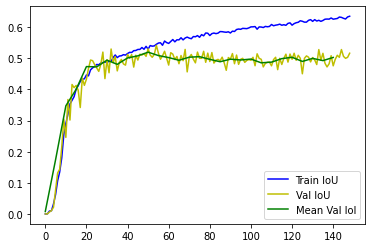

In [24]:
plt.plot(np.arange(len(train_ious)), train_ious, 'b', label="Train IoU")
plt.plot(np.arange(len(train_ious)), val_ious, 'y', label="Val IoU")
plt.plot(np.arange(0, len(train_ious) - 5, 5), mean_5_val_ious, 'g', label="Mean Val IoI")
plt.legend()

### Plot predictions vs mask

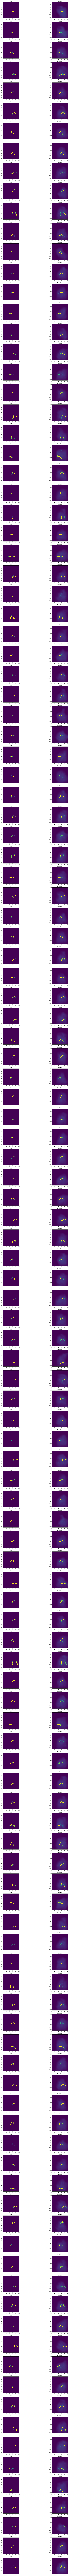

In [25]:
# plot predictions vs mask for 128 random samples
unet.eval()
count = 0
fig, ax = plt.subplots(128,2)
fig.set_figheight(400)
fig.set_figwidth(20)

for x,y,l in train_loader:

    x = x.to(device)
    y = y.numpy()
    with torch.no_grad():
        out = unet(x)

    out = out.cpu().numpy()

    for i in range(count * 16, (count+1)*16):
        ax[i, 0].imshow(y[i - count * 16])
        ax[i, 1].imshow(out[i - count * 16].squeeze())
        
        ax[i, 0].set_title("Mask")
        ax[i, 1].set_title("Prediction")

    count += 1

    if count >= 8:
        break

plt.tight_layout()